# Parameters Initialization
`num_examples`: the number of examples

`input_dim`: the number of neurons in the input layer

`hidden_dim`: the number of neurons in the hidden layer

`output_dim`: the number of neurons in the softmax layer/the number of categories

$\textbf{X}$: `num_examples` * `input_dim` **Matrix**

$\textbf{W}_1$: `input_dim` * `hidden_dim` **Matrix**

$\vec{b}_1$: `1` * `hidden_dim` **Row Vector**

$\textbf{W}_2$: `hidden_dim` * `output_dim` **Matrix**

$\vec{b}_2$: `1` * `output_dim` **Row Vector**

> *Notice:*
>
> In this part, the method $Xavier \ Initialization$ is adopted to initialize the weights.
>
> The weight matrix will be initialized as:
>
> $W \sim \mathcal{N}(0, \frac{2}{n + m})$
> * n: the number of neurons in previous layer
> * m: the number of neurons in current layer
> * Sampling from a normal distribution with mean $0$ and variance $\frac{2}{n+m}$
>
> By using Xavier initialization, the problem of vanishing or exploding gradients can be avoided by effectively keeping the variance of the inputs and outputs the same. This method has been shown in practice to accelerate model convergence and improve model performance.

In [9]:
import numpy as np

# parameters initialization
def initialize_parameters(input_dim, hidden_dim, output_dim):
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(2 / (input_dim + hidden_dim))
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(2 / (hidden_dim + output_dim))
    b2 = np.zeros((1, output_dim))
    
    return W1, b1, W2, b2

# Forward Propagation
`num_examples` * `hidden_dim` input of the hidden layer: $\textbf{z}_1 = \textbf{X} \cdot \textbf{W}_1 + \vec{b}_1$

`num_examples` * `hidden_dim`output of the hidden layer: $\textbf{a}_1 = \tanh{\textbf{z}_1}$

`num_examples` * `output_dim` input of the softmax layer: $\textbf{z}_2 = \textbf{a}_1 \cdot \textbf{W}_2 + \vec{b}_2$

`num_examples` * `output_dim` output of the softmax layer: $\hat{\textbf{y}} = \textbf{probs} = softmax(\textbf{z}_2)$

> *Notice:*
> 
> `NumPy` features a broadcast mechanism that allows arrays of different shapes to be compatible in arithmetic operations. In this case, $\vec{b}_1$ is automatically expanded to `num_examples` * `hidden_dim` size matrix, and $\vec{b}_2$ is automatically expanded to `num_examples` * `output_dim` size matrix

In [5]:
# forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs, a1

# Back Propagation
* Standard cross entropy loss function:
  
  $L = -\sum_j y_j \log{\hat{y}}_j$

* Let's say there is only 1 example input, and let $z_i$ denote the $i$-th element of the input vector of the softmax layer $\vec{z}$, $\hat{y}_i$ denote the $i$-th element of the output vector $\vec{\hat{y}}$, and the derivation of cross entropy loss is given as follows:

$$
\begin{align*}
\frac{\partial L}{\partial z_i}
& = - \sum_k y_k \cdot \frac{\partial \log{\hat{y}_j}}{\partial z_i} \\
& = -\sum_k y_k \cdot \frac{1}{\hat{y}_k} \cdot \frac{\partial{\hat{y}_k}}{\partial z_i} \\
& = -y_i(1-\hat{y}_i)-\sum_{k \neq i} y_k \cdot \frac{1}{\hat{y}_k} \cdot \frac{\partial{\hat{y}_k}}{\partial z_i} \\
& = -y_i + y_i \hat{y}_i + \sum_{k \neq i}{y_k \hat{y}_i} \\
& = -y_i + \hat{y}_i \sum_k y_k \\
& = \hat{y}_i - y_i \\
\end{align*}
$$

* thus we can calculate the gradient descent of parameters:

$$
\begin{align*}
\frac{\partial{L}}{\partial{b}_2} &= \frac{\partial{L}}{\partial{z}_2} \cdot \frac{\partial{z}_2}{\partial{b}_2} = \delta_3 \\
\frac{\partial{L}}{\partial{W}_2} &= \frac{\partial{L}}{\partial{z}_2} \cdot \frac{\partial{z}_2}{\partial{W}_2} = a^{T}_1 \cdot \delta_3 \\
\frac{\partial{L}}{\partial{b}_1} &= \frac{\partial{L}}{\partial{z}_2} \cdot \frac{\partial{z}_2}{\partial{a}_1} \cdot \frac{\partial{a}_1}{\partial{z}_1} \cdot \frac{\partial{z}_1}{\partial{b}_1} = (1 - a^2_1) * (\delta_3 \cdot W^T_2) = \delta_2 \\
\frac{\partial{L}}{\partial{W}_1} &= \frac{\partial{L}}{\partial{z}_2} \cdot \frac{\partial{z}_2}{\partial{a}_1} \cdot \frac{\partial{a}_1}{\partial{z}_1} \cdot \frac{\partial{z}_1}{\partial{W}_1} = X^T \cdot \delta_2
\end{align*}
$$

* $\delta_3$ is the `num_examples` * `output_dim` size error matrix of the softmax layer, and $\delta_2$ is the `num_examples` * `hidden_dim` size error matrix of the hidden layer.

    `np.sum(delta2, axis=0)` sums up each column of $\delta_2$ and get a `1` * `hidden_dim` size row vector,      `np.sum(delat3, axis=0, keepdims=True)` sums up each column of $\delta_3$ and get a `1` * `output_dim` size row vector. Each element of these vectors represents the total error of the corresponding neuron over all samples.

In [3]:
# back propagation
def back_propagation(X, y, probs, a1, W2):
    delta3 = probs
    delta3[range(X.shape[0], y)] -= 1
    dW2 = (a1.T).dot(delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
    dW1 = np.dot(X.T, delta2)
    db1 = np.sum(delta2, axis=0)

    return dW1, db1, dW2, db2

# Update Parameters
$BP$ uses a generalized perceptron learning rule to update the parameters, and the update estimator for an arbitrary parameter $v$ is given by:

$$
v \leftarrow v + \Delta v
$$

Based on the $gradient \ descent$ strategy, the parameters are updated in the direction of the negative gradient of the target:

$$
\Delta v = -\eta \frac{\partial L}{\partial v}
$$

In [ ]:
# parameters update
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    new_model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return new_model

# Prediction

`np.argmax(probs, axis=1)` returns the index of the max element in each row of matrix $\textbf{probs}$, a.k.a the classification results of samples. 

In [ ]:
# prediction
def predict(model, X):
    W1, b1, W2, b2 = model
    probs, _ = forward_propagation(X, W1, b1, W2, b2)
    
    return np.argmax(probs, axis=1)

# Get Prediction Accuracy

* `(y_pred == y)` is a boolean array denoting whether the predicted label `y_pred` equals to the real label `y`
* `(y_pred == y).sum()` calculates the amount of `True` element in the array, a.k.a the number of correctly predicted samples

In [ ]:
def get_accuracy(model, X, y):
    y_pred = predict(model, X)
    
    return (y_pred == y).sum() / X.shape[0]

# Classification Execution

1. dataset loading

    * `sklearn.datasets.make_moons`: a function in the `Scikit-learn` Library used to generate a "half-moon-shaped" dataset. This dataset contains two intersecting semicircular clusters, and is commonly used for demonstration and testing of classification
    * param1 `200`: 200 data points
    * param2 `noise=0.2`: $noise$ is a random pertubation of data points. `0.2` denotes the standard deviation of Gaussian noise added to data points
    * `X`: a matrix of size `200` * `2`. Every sample has 2 features, a.k.a coordinates.
    * `y`: a column vector of `200` rows. Label `0` or `1` in each row stands for 2 different categories.

2. result of logistic regression
3. helper function to draw a decision boundary (Currently I haven't fully understand how it works ToT)

Matplotlib is building the font cache; this may take a moment.


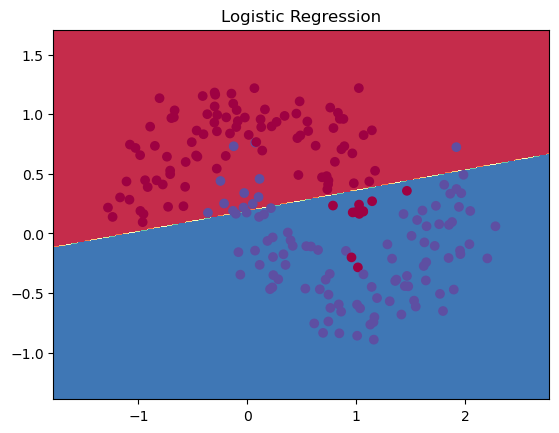

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import sklearn.datasets
import sklearn.linear_model

# dataset loading
np.random.seed(3)
X, y = sklearn.datasets.make_moons(200, noise=0.2)
# plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
# plt.title("half_moon")
# plt.show()

# adopt logistic regression to carry on the classification
lrclf = sklearn.linear_model.LogisticRegressionCV()
lrclf.fit(X, y)

# helper function to draw a decision boundary
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
plot_decision_boundary(lambda x: lrclf.predict(x))
plt.title("Logistic Regression")
plt.show()

4. BP neural networks model training and result producing

* `best_accuracy` = 0.995
* `learning_rate` = 0.001

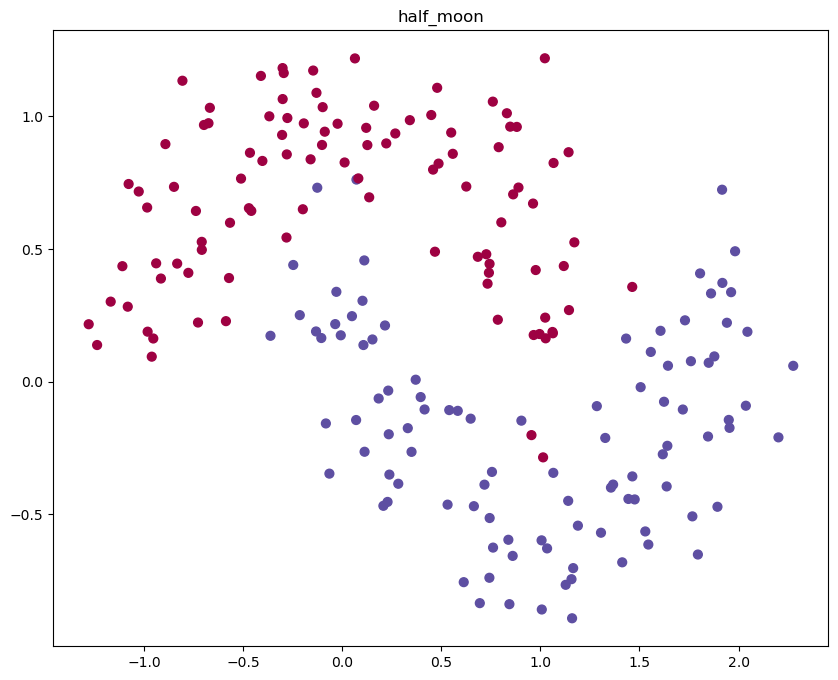

1 iteration, accuracy: 0.195
2 iteration, accuracy: 0.385
3 iteration, accuracy: 0.54
4 iteration, accuracy: 0.62
5 iteration, accuracy: 0.755
6 iteration, accuracy: 0.81
7 iteration, accuracy: 0.84
8 iteration, accuracy: 0.86
9 iteration, accuracy: 0.895
10 iteration, accuracy: 0.9
11 iteration, accuracy: 0.905
12 iteration, accuracy: 0.915
13 iteration, accuracy: 0.915
14 iteration, accuracy: 0.92
15 iteration, accuracy: 0.915
16 iteration, accuracy: 0.925
17 iteration, accuracy: 0.925
18 iteration, accuracy: 0.93
19 iteration, accuracy: 0.94
20 iteration, accuracy: 0.94
21 iteration, accuracy: 0.94
22 iteration, accuracy: 0.945
23 iteration, accuracy: 0.945
24 iteration, accuracy: 0.945
25 iteration, accuracy: 0.945
26 iteration, accuracy: 0.955
27 iteration, accuracy: 0.955
28 iteration, accuracy: 0.96
29 iteration, accuracy: 0.96
30 iteration, accuracy: 0.96
31 iteration, accuracy: 0.96
32 iteration, accuracy: 0.96
33 iteration, accuracy: 0.965
34 iteration, accuracy: 0.965
35 ite

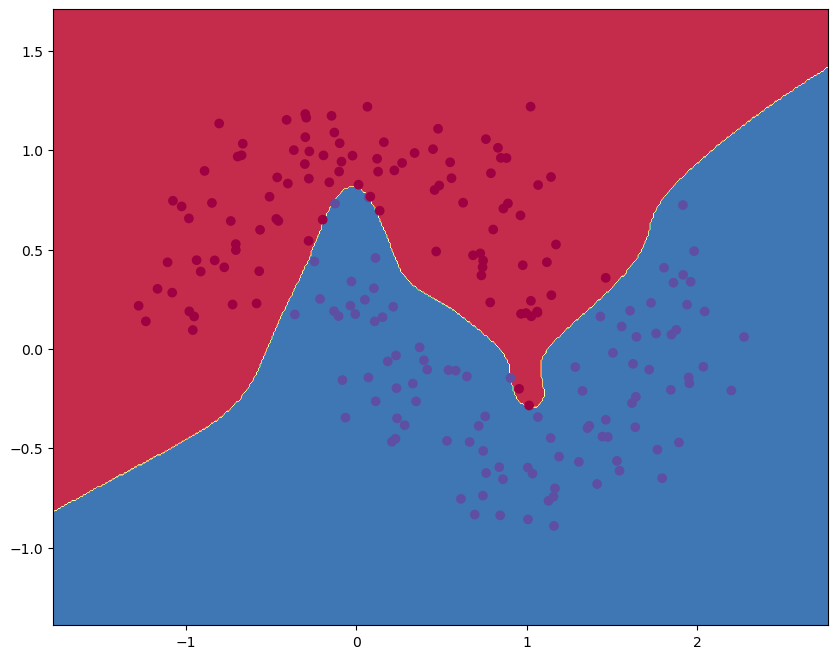

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn  
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size 
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

np.random.seed(3)
X, y = sklearn.datasets.make_moons(200, noise=0.2)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("half_moon")
plt.show()

# helper function to draw a decision boundary
def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    plt.figure()
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# parameters initialization
def initialize_parameters(input_dim, hidden_dim, output_dim):
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(2 / (input_dim + hidden_dim))
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(2 / (hidden_dim + output_dim))
    b2 = np.zeros((1, output_dim))
    
    return W1, b1, W2, b2

# forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs, a1

# back propagation
def back_propagation(X, y, probs, a1, W2):
    delta3 = probs
    delta3[range(X.shape[0]), y] -= 1
    dW2 = (a1.T).dot(delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
    dW1 = (X.T).dot(delta2)
    db1 = np.sum(delta2, axis=0)

    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    new_model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return new_model

def get_accuracy(model, X, y):
    y_pred = predict(model, X)
    
    return (y_pred == y).sum() / X.shape[0]

def predict(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs, _ = forward_propagation(X, W1, b1, W2, b2)
    
    return np.argmax(probs, axis=1)
# model training and result producing
def bpnn_clf(X, y, input_dim, hidden_dim, output_dim, learning_rate):
    W1, b1, W2, b2 = initialize_parameters(input_dim, hidden_dim, output_dim)
    i = 0
    model = {}
    best_accuracy = 0.995
    
    while True:
        i += 1
        probs, a1 = forward_propagation(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = back_propagation(X, y, probs, a1, W2)
        model = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        accuracy = get_accuracy(model, X, y)
        print(f"{i} iteration, accuracy: {accuracy}")
        
        if accuracy < best_accuracy:
            if i > 50000:
                print(f"Can't achieve best accuracy")
                break
            continue
        else:
            print(f"after {i} iterations, best accuracy:{accuracy},\nbest model: {model}")
            plot_decision_boundary(lambda X: predict(model, X))
            plt.show()
            break
        
input_dim = X.shape[1]
hidden_dim = 20
output_dim = 2
bpnn_clf(X, y, input_dim, hidden_dim, output_dim, 0.001)